# Demo RNA Multi-Perceptrón Backpropagation usando clases de Keras para identificar TIPOS de ANIMALES
Adaptado de https://www.tensorflow.org/tutorials/estimator/premade

1) Cargar librerías:

In [13]:
from __future__ import absolute_import, division, print_function, unicode_literals

import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import plot_model

import tensorflow as tf
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from numpy.random import RandomState

from  sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

print("Librerías cargadas")

Librerías cargadas


2) Cargar los datos:

In [2]:
# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demo ANIMALES'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + '/datos/animales.csv')

df.head()

,TIENE_PELO,TIENE_PLUMAS,PONE_HUEVOS,DA_LECHE,ES_AEREO,ES_ACUATICO,ES_PREDADOR,TIENE_DIENTES,TIENE_COLUMNA,RESPIRA,ES_VENENOSO,TIENE_ALETAS,CANT_PATAS,TIENE_COLA,ES_DOMESTICO,TIPO
0,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1
1,1,0,0,1,0,0,0,1,1,1,0,0,4,1,0,1
2,0,0,1,0,0,1,1,1,1,0,0,1,0,1,0,4
3,1,0,0,1,0,0,1,1,1,1,0,0,4,0,0,1
4,1,0,0,1,0,0,1,1,1,1,0,0,4,1,0,1


In [5]:
# define clases (ejemplo ANIMALES)
SPECIES = ['na', 'MAMIFERO', 'AVE', 'REPTIL', 'PEZ', 'ANFIBIO', 'INSECTO', 'INVERTEBRADO']

# define nombre atributo de CLASE (ejemplo ANIMALES)
ClassAttributeName = 'TIPO'

print("Configuración definida de ", ClassAttributeName, ": ", SPECIES)

Configuración definida de  TIPO :  ['na', 'MAMIFERO', 'AVE', 'REPTIL', 'PEZ', 'ANFIBIO', 'INSECTO', 'INVERTEBRADO']


In [6]:
# separa al azar con proporción 80/20
rng = RandomState()

train = df.sample(frac=0.8, random_state=rng)
test = df.loc[~df.index.isin(train.index)]

print("Datos Originales ", df.shape)
print("- Datos para Entrenar ", train.shape)
print("- Datos para Probar ", test.shape)

# genera los datos solo con la clase para entrenar y probar
train_y = train.pop(ClassAttributeName)
test_y = test.pop(ClassAttributeName)

Datos Originales  (101, 16)
- Datos para Entrenar  (81, 16)
- Datos para Probar  (20, 16)


In [16]:
# genera los vectores con los datos a usar por el modelo
x_train = np.array(train)
y_train = np.array(train_y)
x_test = np.array(test)
y_test = np.array(test_y)

print("> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))

print("\n\n> Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))

print("\n\n> Para Ambos: ")
print(" - dictMapeo: ", SPECIES)

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (81, 15)
 - y_train (cant):  81


> Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (20, 15)
 - y_test (cant):  20


> Para Ambos: 
 - dictMapeo:  ['na', 'MAMIFERO', 'AVE', 'REPTIL', 'PEZ', 'ANFIBIO', 'INSECTO', 'INVERTEBRADO']


3) Establecer el modelo para la RNA

In [43]:
# define tamaño de datos de entrada 
num_inputs = x_train.shape[1]

# cantidad de neuronas ocultas 
hidden_layers = [ num_inputs*3//4, num_inputs//2 ] 

# define tamaño de datos de salida (las clases están codificadas en un único número)
num_outputs = 1

# cantidad de épocas del entrenamiento
cantEpocas = 300

print("Configuración de RNA MLP Backpropagation definida: [", num_inputs, hidden_layers, num_outputs," ] ")

Configuración de RNA MLP Backpropagation definida: [ 15 [11, 7] 1  ] 


Modelo creado con  4  capas:
Model: "RNA"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 15)]              0         
_________________________________________________________________
hidd_1 (Dense)               (None, 11)                176       
_________________________________________________________________
hidd_2 (Dense)               (None, 7)                 84        
_________________________________________________________________
output (Dense)               (None, 1)                 8         
Total params: 268
Trainable params: 268
Non-trainable params: 0
_________________________________________________________________




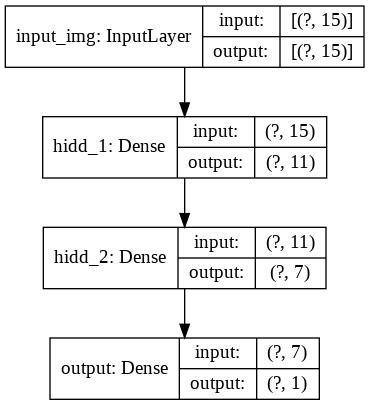

In [44]:
# define la arquitectura de capas teniendo en cuenta la definición dada anteriomente
input_img_Lay = Input(shape=(num_inputs,), name='input_img') # capa de entrada
eachLay = input_img_Lay
auxName = 'hidd_'
auxId = 1 
for num_hid in hidden_layers:  
    
    # agrega la capa oculta
    auxlayerName = auxName+str(auxId)
    auxId = auxId + 1
    eachLay = Dense(num_hid, name=auxlayerName)(eachLay) # capas ocultas

output_img_Lay = Dense(num_outputs, activation=None, name='output')(eachLay) # capa de salida

# genera el modelo RNA MLP Backpropagation
model = Model(input_img_Lay, output_img_Lay, name='RNA')
model.compile(optimizer='rmsprop', loss='mse', metrics=['accuracy'])

print("Modelo creado con ", len(model.layers), " capas:")
model.summary()
print("\n")
plot_model(model, show_layer_names=True, show_shapes=True)


4) Entrenar el modelo de la RNA:

In [45]:
# lleva a cabo el entrenamiento
model.fit(x_train, y_train,
                epochs = cantEpocas, 
                batch_size = 5 ) 

Epoch 1/300
17/17 [==============================] - 0s 967us/step - loss: 7.9043 - accuracy: 0.3580
Epoch 2/300
17/17 [==============================] - 0s 1ms/step - loss: 6.3214 - accuracy: 0.4074
Epoch 3/300
17/17 [==============================] - 0s 995us/step - loss: 5.6664 - accuracy: 0.4074
Epoch 4/300
17/17 [==============================] - 0s 969us/step - loss: 5.0982 - accuracy: 0.4198
Epoch 5/300
17/17 [==============================] - 0s 854us/step - loss: 4.6057 - accuracy: 0.4198
Epoch 6/300
17/17 [==============================] - 0s 902us/step - loss: 4.1662 - accuracy: 0.4198
Epoch 7/300
17/17 [==============================] - 0s 914us/step - loss: 3.7881 - accuracy: 0.4198
Epoch 8/300
17/17 [==============================] - 0s 890us/step - loss: 3.3964 - accuracy: 0.3951
Epoch 9/300
17/17 [==============================] - 0s 913us/step - loss: 3.0857 - accuracy: 0.3827
Epoch 10/300
17/17 [==============================] - 0s 889us/step - loss: 2.7744 - accuracy

In [47]:
# función auxiliar para probar el modelo entrenado en detalle
def probarModelo(x, y, clases_map):

    # procesa las imágenes de prueba con el modelo 
    predClass = model.predict(x)

    # muestra los resultados con las imágenes 
    umbralClas = 0.5
    classPreds = []
    classReal = []
    for i in range(len(x)):

        # prepara salida
        clReal = clases_map[ y[i] ] 
        idclPred = predClass[i][0]

        ## determina clase predecida de acuerdo al umbral de clasificación
        idclPredRnd = int(idclPred)
        if (idclPred - idclPredRnd)>0.5 and (idclPredRnd+1)<len(clases_map):
                idclPredRnd = idclPredRnd + 1

        if idclPredRnd<0 or idclPredRnd>=len(clases_map):
            clPred = "CLASE " + str(idclPredRnd) + " INVÁLIDA"
        else:      
            clPred = clases_map[ idclPredRnd ]

        classReal.append( clReal )
        classPreds.append( clPred )

        strTitulo = 'Real: ' + clReal + ' / RNA: ' 
        strTitulo = strTitulo + clPred + ' (' + str( idclPred ) +')'   
        strTitulo = strTitulo + ": " + ("ok" if (clPred==clReal) else "error!")

        # muestra comparación con la imagen
        print(strTitulo)

    # muestra reporte de clasificación
    print("\n Reporte de Clasificación: ")
    print(classification_report(classReal, classPreds))

    # muestra matriz de confusion
    print('\nMatriz de Confusión: ')
    cm = confusion_matrix(classReal, classPreds, labels=clases_map)
    cmtx = pd.DataFrame(
        cm, 
        index=['r:{:}'.format(x) for x in clases_map], 
        columns=['p:{:}'.format(x) for x in clases_map]
      )
    print(cmtx)
    print("\n")

    print("\n>Resultados: ")


# prueba con los datos de prueba
print("*** Resultados con datos de Entrenamiento: ")
probarModelo(x_train, y_train, SPECIES)

*** Resultados con datos de Entrenamiento: 
Real: INVERTEBRADO / RNA: INVERTEBRADO (7.1366234): ok
Real: PEZ / RNA: PEZ (3.90702): ok
Real: AVE / RNA: AVE (1.8430223): ok
Real: INVERTEBRADO / RNA: INVERTEBRADO (6.5815196): ok
Real: INVERTEBRADO / RNA: INVERTEBRADO (7.0751786): ok
Real: INVERTEBRADO / RNA: INVERTEBRADO (7.0444555): ok
Real: ANFIBIO / RNA: PEZ (3.9003325): error!
Real: AVE / RNA: AVE (1.7612603): ok
Real: INSECTO / RNA: INSECTO (5.9847593): ok
Real: AVE / RNA: AVE (1.9396105): ok
Real: AVE / RNA: AVE (2.0705805): ok
Real: AVE / RNA: AVE (1.8430223): ok
Real: INSECTO / RNA: INSECTO (6.0665207): ok
Real: INSECTO / RNA: INSECTO (6.4253774): ok
Real: PEZ / RNA: PEZ (3.77605): ok
Real: MAMIFERO / RNA: MAMIFERO (0.8820715): ok
Real: MAMIFERO / RNA: MAMIFERO (1.1623948): ok
Real: MAMIFERO / RNA: MAMIFERO (0.8125475): ok
Real: MAMIFERO / RNA: MAMIFERO (0.8125475): ok
Real: MAMIFERO / RNA: MAMIFERO (0.8125475): ok
Real: REPTIL / RNA: REPTIL (3.0925884): ok
Real: MAMIFERO / RNA: M

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


6) Evaluar el modelo de la RNA entrenado con los datos de prueba:

In [48]:
 # evalua al modelo entrenado
resEval = model.evaluate(x_test, y_test)
print("\n>Evaluación del Modelo: ")
print("    - Error: ", resEval[0])
print("    - Exactitud: ", resEval[1]*100)
print("\n")

# prueba con los datos de entrenamiento
print("\n\n*** Resultados con datos de Entrenamiento: ")
probarModelo(x_test, y_test, SPECIES)

1/1 [==============================] - 0s 1ms/step - loss: 0.2226 - accuracy: 0.3500

>Evaluación del Modelo: 
    - Error:  0.2225540429353714
    - Exactitud:  34.99999940395355




*** Resultados con datos de Entrenamiento: 
Real: MAMIFERO / RNA: MAMIFERO (0.9207687): ok
Real: PEZ / RNA: PEZ (3.77605): ok
Real: MAMIFERO / RNA: MAMIFERO (1.133501): ok
Real: AVE / RNA: AVE (1.6302903): ok
Real: INSECTO / RNA: INVERTEBRADO (6.788627): error!
Real: ANFIBIO / RNA: PEZ (3.8409457): error!
Real: MAMIFERO / RNA: MAMIFERO (0.5188217): ok
Real: AVE / RNA: AVE (1.6302903): ok
Real: MAMIFERO / RNA: MAMIFERO (0.8125475): ok
Real: AVE / RNA: AVE (1.8430223): ok
Real: AVE / RNA: AVE (1.7612603): ok
Real: PEZ / RNA: PEZ (3.77605): ok
Real: MAMIFERO / RNA: MAMIFERO (0.84083045): ok
Real: MAMIFERO / RNA: MAMIFERO (1.0252798): ok
Real: MAMIFERO / RNA: MAMIFERO (0.89430976): ok
Real: PEZ / RNA: PEZ (3.6084425): ok
Real: INSECTO / RNA: INVERTEBRADO (6.788627): error!
Real: ANFIBIO / RNA: PEZ (4.1395235)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
